In [1]:
## Load in result for Variance Figure

import torch
import numpy as np
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision import datasets
import scipy.stats as stats 
import matplotlib.pyplot as plt
import utils.metrics as metrics

In [2]:
def array_to_numpy(x):
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    elif isinstance(x, np.ndarray):
        return x
    else:
        return 'ERR'

def ax_violin(ax,var_dict,set_sigma=False, legend_true=False, fs = 12, title=None):
    ticks = list(var_dict.keys())
    
    id_correct_var_list = []
    id_incorrect_var_list = []
    ood_var_list = []
    for key in var_dict.keys():
        pi_correct = array_to_numpy(var_dict[key]['id_correct'])
        pi_incorrect = array_to_numpy(var_dict[key]['id_incorrect'])
        po = array_to_numpy(var_dict[key]['ood'])
        
        id_correct_var_list.append(pi_correct.tolist())
        id_incorrect_var_list.append(pi_incorrect.tolist())
        ood_var_list.append(po.tolist())

    id_vars_plot = ax.violinplot(id_correct_var_list,
                                positions=np.array(
        np.arange(len(id_correct_var_list)))*2-0.6, 
                                points=1000, widths=0.6,
                     showmeans=False, showextrema=False, showmedians=True)
    id_vars_plot_2 = ax.violinplot(id_incorrect_var_list,
                                positions=np.array(
        np.arange(len(id_incorrect_var_list)))*2, 
                                points=1000, widths=0.6,
                     showmeans=False, showextrema=False, showmedians=True)
    ood_vars_plot = ax.violinplot(ood_var_list,
                                positions=np.array(
        np.arange(len(ood_var_list)))*2+0.6,
                                points=1000, widths=0.6,
                     showmeans=False, showextrema=False, showmedians=True)
    
    for pc in id_vars_plot['bodies']:
        # pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(0.4)

    for pc in id_vars_plot_2['bodies']:
        # pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(0.4)

    for pc in ood_vars_plot['bodies']:
        # pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(0.4)
    

    def define_box_properties(plot_name, color_code, label):
        for k, v in plot_name.items():
            plt.setp(plot_name.get(k), color=color_code)

        if legend_true:    
            # use plot function to draw a small line to name the legend.
            plt.plot([], c=color_code, label=label)
            plt.legend(fontsize=fs)
    
    # # setting colors for each groups
    define_box_properties(id_vars_plot, '#008000', 'ID Correct')
    define_box_properties(id_vars_plot_2, '#D7191C', 'ID Incorrect')
    define_box_properties(ood_vars_plot, '#2C7BB6', 'OOD')
    
    ax.set_xticks(np.arange(0, len(ticks) * 2, 2), ticks)
    ax.set_xlim(-1.2, len(ticks)*2 - 0.8)
    if set_sigma:
        ax.set_ylabel('$\sigma^2$', fontsize=fs)
    ax.tick_params(labelsize=fs)

    if title is not None:
        ax.set_title(title, fontsize=fs)

In [6]:
def add_baseline(prob_var_dict,test_data,ood_test_data):
    ## Add baseline method    
    S = 10
    scale_n = 1
    scale_d = 0.1
    base_method = torch.distributions.dirichlet.Dirichlet(torch.tensor([scale_d]*10))
    sample = base_method.sample(torch.Size([S,len(torch.tensor(test_data.targets))]))
    sample_ood = base_method.sample(torch.Size([S,len(torch.tensor(ood_test_data.targets))]))

    sample = (torch.randn((S,len(torch.tensor(test_data.targets)),10)) * scale_n).softmax(2)
    sample_ood = (torch.randn((S,len(torch.tensor(test_data.targets)),10)) * scale_n).softmax(2)

    sample_mean = sample.mean(0).argmax(1)

    pi_correct, pi_incorrect = metrics.sort_preds(sample,torch.tensor(test_data.targets))

    max_index = pi_correct.mean(0).argmax(1)
    pi_correct_var = pi_correct[:,range(len(max_index)),max_index].var(0)

    max_index = pi_incorrect.mean(0).argmax(1)
    pi_incorrect_var = pi_incorrect[:,range(len(max_index)),max_index].var(0)

    max_index = sample_ood.mean(0).argmax(1)
    po_var = sample_ood[:,range(len(max_index)),max_index].var(0)

    prob_var_dict['BASE'] = {'id_correct': pi_correct_var,
                        'id_incorrect': pi_incorrect_var,
                        'ood': po_var}
    return prob_var_dict

In [4]:
svhn

{'NUQLS': {'id_correct': tensor([9.6937e-07, 7.7088e-08, 1.0766e-04,  ..., 1.5166e-07, 7.3106e-04,
          4.6918e-08], dtype=torch.float64),
  'id_incorrect': tensor([1.3266e-03, 7.2766e-04, 1.7080e-04,  ..., 1.6530e-04, 2.3323e-05,
          2.2076e-03], dtype=torch.float64),
  'ood': tensor([0.0009, 0.0005, 0.0024,  ..., 0.0268, 0.0006, 0.0030],
         dtype=torch.float64)},
 'DE': {'id_correct': tensor([0.0426, 0.0731, 0.0882,  ..., 0.0954, 0.0693, 0.1021],
         dtype=torch.float64),
  'id_incorrect': tensor([0.1187, 0.0156, 0.0444,  ..., 0.0433, 0.0350, 0.0316],
         dtype=torch.float64),
  'ood': tensor([0.0321, 0.0247, 0.0129,  ..., 0.0142, 0.0375, 0.0392],
         dtype=torch.float64)},
 'SWAG': {'id_correct': tensor([3.1072e-32, 2.8519e-32, 3.0379e-32,  ..., 5.6245e-32, 5.6377e-32,
          5.9498e-32], dtype=torch.float64),
  'id_incorrect': tensor([2.6714e-32, 2.8239e-32, 3.3398e-32,  ..., 5.9132e-32, 6.3941e-32,
          5.7809e-32], dtype=torch.float64),
  '

C:\Users\s4531973\AppData\Local\Temp\ipykernel_8020\2753395284.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


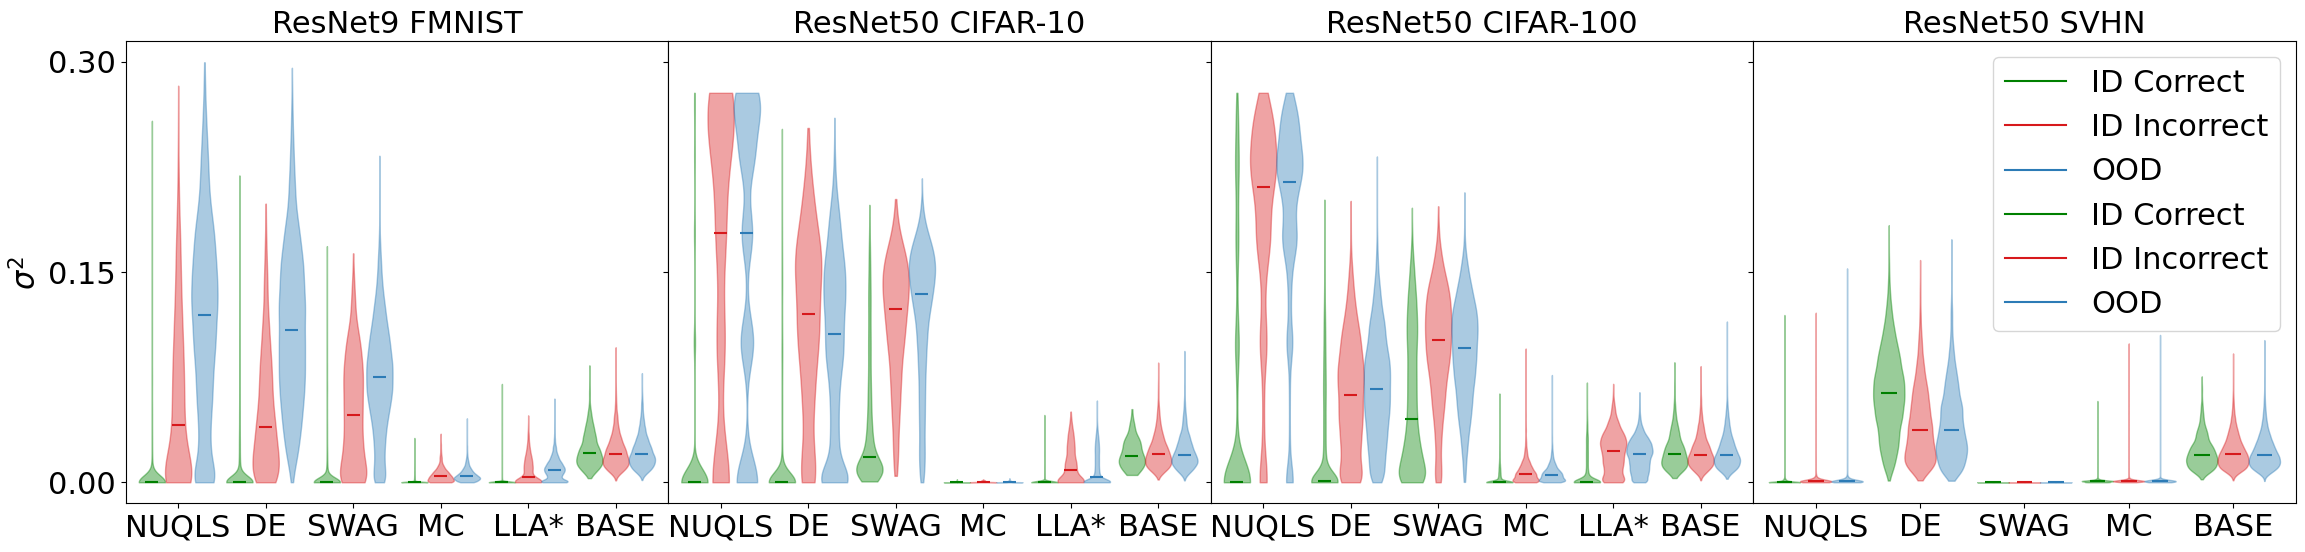

In [6]:
pvd_r9_fm = torch.load('paper/pvd_r9_fm.pt')
pvd_r50_cifar = torch.load('paper/pvd_r50_cifar.pt')
pvd_r50_cifar100 = torch.load('paper/pvd_r50_cifar100.pt')
svhn = torch.load('results\image_classification\svhn_resnet50\_7_5_7_22\prob_var_dict_0.pt')

pvd_r9_fm['LLA*'] = pvd_r9_fm.pop('LLA')
pvd_r9_fm['BASE'] = pvd_r9_fm.pop('BASE')

pvd_r50_cifar['LLA*'] = pvd_r50_cifar.pop('LLA')
pvd_r50_cifar['BASE'] = pvd_r50_cifar.pop('BASE')

pvd_r50_cifar100['LLA*'] = pvd_r50_cifar100.pop('LLA')
pvd_r50_cifar100['BASE'] = pvd_r50_cifar100.pop('BASE')

w, h, fs = 28, 6, 22
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,facecolor='white', figsize = (1*w,1*h), sharey=True)
fig.subplots_adjust(wspace=0)
ax_violin(ax1,pvd_r9_fm, set_sigma=True, fs=fs, title='ResNet9 FMNIST')
ax_violin(ax2,pvd_r50_cifar, fs=fs, title='ResNet50 CIFAR-10')
ax_violin(ax3,pvd_r50_cifar100, legend_true=True, fs=fs, title='ResNet50 CIFAR-100')
ax_violin(ax4,svhn, legend_true=True, fs=fs, title='ResNet50 SVHN')
ax1.set_yticks(np.array((0,0.15,0.3)))

fig.show()
fig.savefig('violin_plot_uncertainty_svhn.pdf',format='pdf',bbox_inches='tight')


C:\Users\s4531973\AppData\Local\Temp\ipykernel_22464\3621214810.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


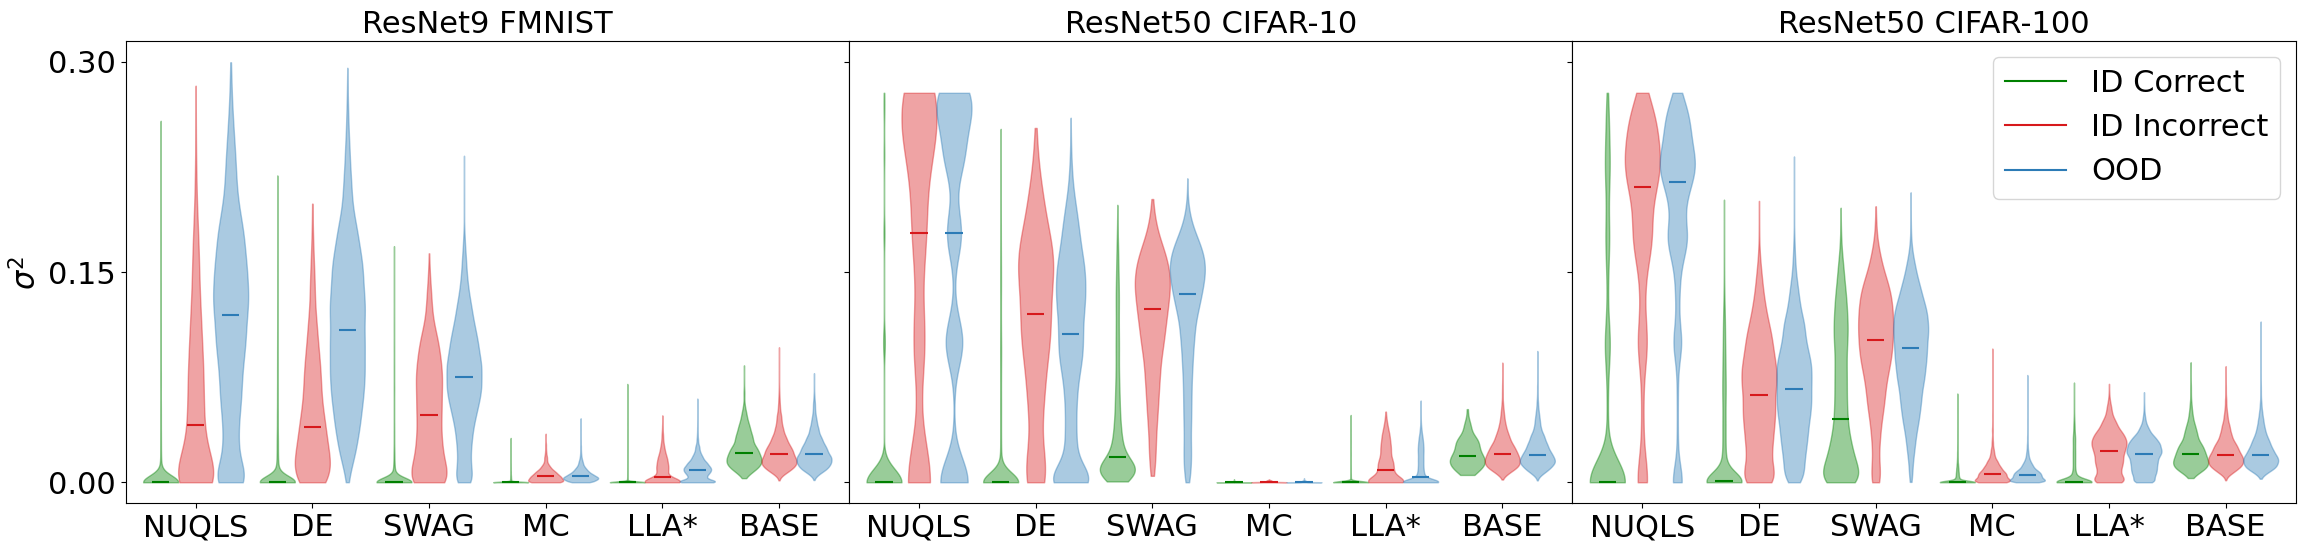

In [4]:
pvd_r9_fm = torch.load('paper/pvd_r9_fm.pt')
pvd_r50_cifar = torch.load('paper/pvd_r50_cifar.pt')
pvd_r50_cifar100 = torch.load('paper/pvd_r50_cifar100.pt')

pvd_r9_fm['LLA*'] = pvd_r9_fm.pop('LLA')
pvd_r9_fm['BASE'] = pvd_r9_fm.pop('BASE')

pvd_r50_cifar['LLA*'] = pvd_r50_cifar.pop('LLA')
pvd_r50_cifar['BASE'] = pvd_r50_cifar.pop('BASE')

pvd_r50_cifar100['LLA*'] = pvd_r50_cifar100.pop('LLA')
pvd_r50_cifar100['BASE'] = pvd_r50_cifar100.pop('BASE')

w, h, fs = 28, 6, 22
fig, (ax1,ax2,ax3) = plt.subplots(1,3,facecolor='white', figsize = (1*w,1*h), sharey=True)
fig.subplots_adjust(wspace=0)
ax_violin(ax1,pvd_r9_fm, set_sigma=True, fs=fs, title='ResNet9 FMNIST')
ax_violin(ax2,pvd_r50_cifar, fs=fs, title='ResNet50 CIFAR-10')
ax_violin(ax3,pvd_r50_cifar100, legend_true=True, fs=fs, title='ResNet50 CIFAR-100')
ax1.set_yticks(np.array((0,0.15,0.3)))

fig.show()
fig.savefig('violin_plot_uncertainty.pdf',format='pdf',bbox_inches='tight')


In [10]:
skew_median(pvd_r9_fm)

method = NUQLS
sample skew: id_correct = 4.35, id_incorrect = 0.935, ood = 0.048
pearsons first moment: id_correct = 0.292, id_incorrect = 1.0, ood = 1.67
pearsons second moment: id skew = 0.876, id skew = 0.899, ood_skew = -0.191
median id_correct = 2.45e-08, id_incorrect = 0.0412, ood = 0.119, |diff| (ood-id_c) = 0.119

method = DE
sample skew: id_correct = 3.51, id_incorrect = 0.928, ood = 0.321
pearsons first moment: id_correct = 0.377, id_incorrect = 1.17, ood = 2.0
pearsons second moment: id skew = 1.13, id skew = 0.719, ood_skew = 0.151
median id_correct = 1.31e-05, id_incorrect = 0.0397, ood = 0.109, |diff| (ood-id_c) = 0.109

method = SWAG
sample skew: id_correct = 3.72, id_incorrect = 0.378, ood = 0.0756
pearsons first moment: id_correct = 0.334, id_incorrect = 1.31, ood = 1.91
pearsons second moment: id skew = 1.0, id skew = 0.187, ood_skew = -0.0474
median id_correct = 4.64e-07, id_incorrect = 0.0478, ood = 0.0748, |diff| (ood-id_c) = 0.0748

method = MC
sample skew: id_cor

In [11]:
skew_median(pvd_r50_cifar)

method = NUQLS
sample skew: id_correct = 3.15, id_incorrect = -0.499, ood = -0.445
pearsons first moment: id_correct = 0.325, id_incorrect = 1.5, ood = 1.49
pearsons second moment: id skew = 0.974, id skew = -0.434, ood_skew = -0.501
median id_correct = 0.0, id_incorrect = 0.178, ood = 0.178, |diff| (ood-id_c) = 0.178

method = DE
sample skew: id_correct = 2.74, id_incorrect = -0.273, ood = -0.142
pearsons first moment: id_correct = 0.394, id_incorrect = 1.79, ood = 1.51
pearsons second moment: id skew = 1.18, id skew = -0.289, ood_skew = -0.412
median id_correct = 8.29e-08, id_incorrect = 0.12, ood = 0.106, |diff| (ood-id_c) = 0.106

method = SWAG
sample skew: id_correct = 1.37, id_incorrect = -0.604, ood = -0.832
pearsons first moment: id_correct = 0.881, id_incorrect = 2.58, ood = 2.52
pearsons second moment: id skew = 1.5, id skew = -0.549, ood_skew = -0.86
median id_correct = 0.0181, id_incorrect = 0.123, ood = 0.134, |diff| (ood-id_c) = 0.116

method = MC
sample skew: id_correct 

In [12]:
skew_median(pvd_r50_cifar100)

method = NUQLS
sample skew: id_correct = 1.08, id_incorrect = -1.15, ood = -1.37
pearsons first moment: id_correct = 0.683, id_incorrect = 2.38, ood = 2.68
pearsons second moment: id skew = 2.05, id skew = -1.07, ood_skew = -1.0
median id_correct = 1e-08, id_incorrect = 0.211, ood = 0.214, |diff| (ood-id_c) = 0.214

method = DE
sample skew: id_correct = 1.48, id_incorrect = 0.241, ood = 0.269
pearsons first moment: id_correct = 0.655, id_incorrect = 1.55, ood = 1.79
pearsons second moment: id skew = 1.9, id skew = 0.00992, ood_skew = 0.0895
median id_correct = 0.000873, id_incorrect = 0.0624, ood = 0.0665, |diff| (ood-id_c) = 0.0656

method = SWAG
sample skew: id_correct = 0.508, id_incorrect = -0.47, ood = -0.233
pearsons first moment: id_correct = 1.18, id_incorrect = 2.38, ood = 2.6
pearsons second moment: id skew = 0.776, id skew = -0.364, ood_skew = -0.226
median id_correct = 0.0449, id_incorrect = 0.101, ood = 0.0956, |diff| (ood-id_c) = 0.0507

method = MC
sample skew: id_correc